In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [11]:
print ((Measurements.__table__.columns))

ImmutableColumnCollection(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs)


In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.

# MTwelve = session.query(Measurements.date).order_by(Measurements.date.desc()).limit(1).all()
maxD = session.query(func.max(Measurements.date)).first()
(maxD[0])

'2017-08-23'

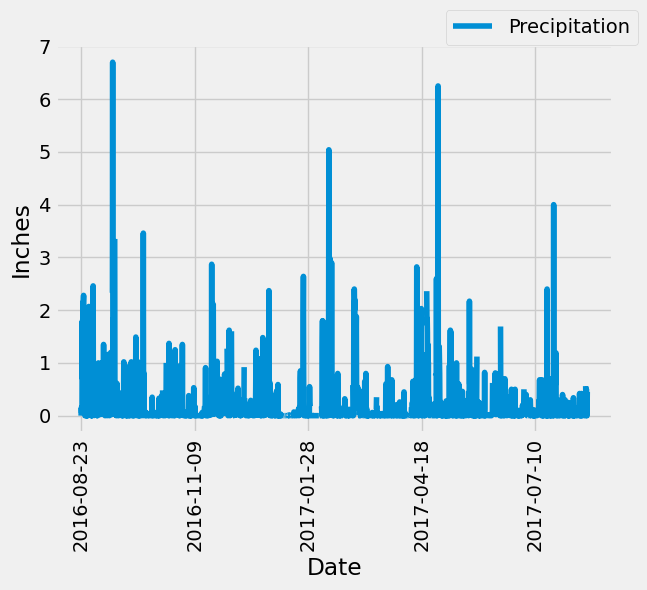

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
query_date = (str(dt.datetime.strptime(maxD[0], '%Y-%m-%d') - dt.timedelta(days=365)))[:10]
# Perform a query to retrieve the data and precipitation scores
DPscores = session.query(Measurements.date, (Measurements.prcp)).filter(func.strftime('%Y-%m-%d', Measurements.date) >= query_date).order_by(Measurements.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column # Sort the dataframe by date
DPscores_df = pd.DataFrame(DPscores, columns=["Date","Precipitation"]).set_index("Date").sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data

DPscores_df.plot().legend(loc=(0.7,1))
# plt.gcf().autofmt_xdate(rotation=90)
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")

plt.show()


In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
DPsum = session.query(Measurements.date, (Measurements.prcp)).order_by(Measurements.date).all()
Pdata = pd.DataFrame(DPsum, columns=["Date","Precipitation"]).set_index("Date").sort_values("Date")
Pdata['year'] = pd.to_datetime(Pdata.index, format='%Y-%m-%d')

Pdata = Pdata.groupby([Pdata['year'].dt.year]).agg({"Precipitation": ["min","median","max", "mean",  "var", "std", "count"]})
Pdata

Precipitation                                                  
               min median    max      mean       var       std count
year                                                                
2010           0.0   0.01   5.04  0.138523  0.169740  0.411995  2681
2011           0.0   0.02   8.81  0.163735  0.237739  0.487584  2565
2012           0.0   0.00   6.38  0.116381  0.178838  0.422892  2470
2013           0.0   0.01   8.06  0.155546  0.216654  0.465461  2474
2014           0.0   0.02  11.53  0.178560  0.259564  0.509474  2402
2015           0.0   0.02   6.83  0.199200  0.234719  0.484478  2175
2016           0.0   0.02   9.64  0.179845  0.256403  0.506363  2069
2017           0.0   0.00   6.25  0.165927  0.206037  0.453913  1267

# Exploratory Station Analysis

In [452]:
# Design a query to calculate the total number stations in the dataset
Ssum = session.query(func.count(Stations.name)).all()
Ssum[0][0]

9

In [36]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
Sbyma = session.query(Measurements.station, func.count(Measurements.date)).group_by(Measurements.station).order_by(func.count(Measurements.date).desc()).all()
Sbyma

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
LHA = [Measurements.station, 
            func.min(Measurements.tobs),
            func.max(Measurements.tobs),
            func.avg(Measurements.tobs),]
LHAtemps = session.query(*LHA).filter(Measurements.station == 'USC00519281').group_by(Measurements.station).order_by(Measurements.date).all()
LHAtemps

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

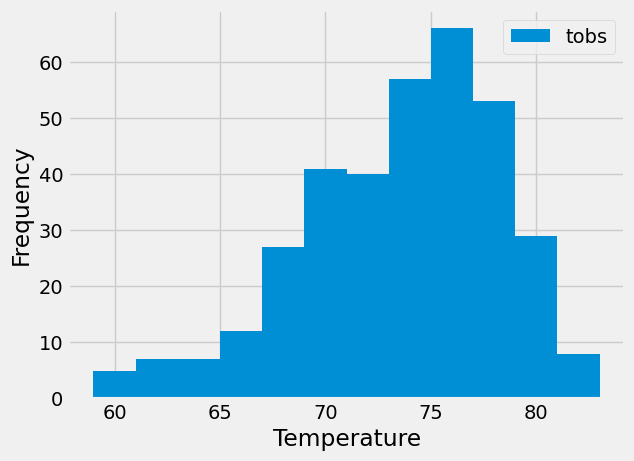

In [459]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
DPtobs = session.query(Measurements.date, Measurements.tobs).filter(Measurements.station == "USC00519281")\
    .filter(func.strftime('%Y-%m-%d', Measurements.date) >= query_date).all()
DPtobs_df = pd.DataFrame(DPtobs, columns=["Date","tobs"]).set_index("Date").sort_values("Date")
DPtobs_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.show()


# Close session

In [460]:
# Close Session
session.close()